In [1]:
# Install dependencies
!pip install wandb xgboost scikit-learn matplotlib torch


In [2]:

# Imports
import os, random, math, copy
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple

In [3]:
# Set seeds for reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# List files in the dataset directory to confirm location
dataset_path_in_drive = "/content/drive/MyDrive/dataset" # Update this path if your dataset is located elsewhere in your Drive
!ls "{dataset_path_in_drive}"

'Amazon Sale Report.csv'		'P  L March 2021.csv'
'Cloud Warehouse Compersion Chart.csv'	 retail_price.csv
'Expense IIGF.csv'			 retail_store_inventory.csv
'International sale Report.csv'		'Sale Report.csv'
 May-2022.csv


In [6]:
# Update the base_dir to point to the dataset directory in Google Drive
base_dir = dataset_path_in_drive
sales_csv = os.path.join(base_dir, "Sale Report.csv")        # adapt if different
retail_price_csv = os.path.join(base_dir, "retail_price.csv")

# Load sample data (modify column names if needed)
sales_df = pd.read_csv(sales_csv, low_memory=False)
if os.path.exists(retail_price_csv):
    price_df = pd.read_csv(retail_price_csv, low_memory=False)
else:
    price_df = None

print("Sales rows:", len(sales_df))
print("Sample columns:", sales_df.columns.tolist()[:20])

Sales rows: 9271
Sample columns: ['index', 'SKU Code', 'Design No.', 'Stock', 'Category', 'Size', 'Color']


In [7]:
# We'll create a simple price-response model using aggregated data per SKU.
# Ensure columns: 'SKU Code' (or 'SKU'), 'Price', 'Units Sold' exist. Adapt if names differ.
# Try common names:
if 'SKU Code' in sales_df.columns:
    sku_col = 'SKU Code'
elif 'SKU' in sales_df.columns:
    sku_col = 'SKU'
else:
    sku_col = sales_df.columns[0]  # fall back

price_col = 'Price' if 'Price' in sales_df.columns else None
units_col = 'Units Sold' if 'Units Sold' in sales_df.columns else None

# If dataset does not have those columns, synthesize a demo dataset
if price_col is None or units_col is None:
    print("Could not find Price or Units Sold columns. Generating a synthetic dataset for demo.")
    n = 2000
    sales_df = pd.DataFrame({
        'SKU': np.random.choice(['A','B','C'], size=n),
        'Price': np.random.choice([100,120,140,160,180], size=n),
        'Units Sold': (np.random.poisson(20, size=n) * np.random.rand(n)).astype(int)
    })
    sku_col = 'SKU'; price_col='Price'; units_col='Units Sold'

Could not find Price or Units Sold columns. Generating a synthetic dataset for demo.


In [8]:

# Compute simple elasticity per SKU by linear regression on log(price)->log(demand)
elasticity = {}
for sku, g in sales_df.groupby(sku_col):
    g = g[(g[price_col] > 0) & (g[units_col] > 0)]
    if len(g) < 5:
        continue
    X = np.log(g[[price_col]].values)
    y = np.log(g[units_col].values)
    lr = LinearRegression().fit(X, y)
    elast = lr.coef_[0]  # slope of log-demand vs log-price
    elasticity[sku] = float(elast)
print("Computed elasticity for SKUs (sample):", dict(list(elasticity.items())[:5]))


Computed elasticity for SKUs (sample): {'A': 0.11671119131165132, 'B': 0.04493615520907583, 'C': -0.3105472065669367}


In [9]:
# Simulation environment:
class PriceEnv:
    def __init__(self, sku_list, base_price_map, elasticity_map, horizon=30):
        self.skus = sku_list
        self.base_price = base_price_map
        self.elasticity = elasticity_map
        self.horizon = horizon
        self.t = 0
        self.current_sku = 0
    def reset(self):
        self.t = 0
        self.current_sku = 0
        state = self._get_state()
        return state
    def _get_state(self):
        sku = self.skus[self.current_sku]
        return np.array([self.base_price[sku], self.t], dtype=np.float32)
    def step(self, action_price):
        # action_price: price for current sku (float)
        sku = self.skus[self.current_sku]
        base = self.base_price[sku]
        elast = self.elasticity.get(sku, -1.0)  # default elasticity
        # Simple constant elasticity model: demand = base_demand * (price/base_price)^{elast}
        base_demand = 20.0  # baseline demand per period (tunable)
        demand = base_demand * (action_price / base) ** elast
        demand = max(0.0, demand)
        revenue = action_price * demand
        reward = revenue
        self.t += 1
        done = (self.t >= self.horizon)
        # Move to next sku for variety
        self.current_sku = (self.current_sku + 1) % len(self.skus)
        next_state = self._get_state()
        return next_state, reward, done, {'demand': demand, 'revenue': revenue, 'sku': sku}


In [10]:
# Build toy SKU lists from elasticity results
skus = list(elasticity.keys())
if len(skus) == 0:
    skus = ['A','B','C']
base_price_map = {}
for s in skus:
    base_price_map[s] = float(sales_df[sales_df[sku_col]==s][price_col].median()) if s in sales_df[sku_col].values else 100.0
env = PriceEnv(skus, base_price_map, elasticity, horizon=100)

In [11]:
# Simple DQN (small MLP)
class DQN(nn.Module):
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)  # output: expected revenue for chosen price; we'll learn to pick better price via action sampling
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DQN(input_dim=2).to(device)
target = copy.deepcopy(model)
opt = optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

In [12]:
# We'll use discrete action space: relative multipliers of base price
action_multipliers = np.array([0.7, 0.85, 1.0, 1.15, 1.3])


In [13]:
# Replay buffer
Transition = namedtuple('Transition', ('state', 'action_idx', 'reward', 'next_state', 'done'))
buffer = deque(maxlen=50000)
batch_size = 64

def select_action(state, eps=0.1):
    if np.random.rand() < eps:
        return np.random.randint(0, len(action_multipliers))
    else:
        # Greedy: evaluate each possible action by feeding state + action to network
        vals=[]
        s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        for a in action_multipliers:
            # include action as a feature by replacing price in state
            inp = s.clone()
            inp[0,0] = inp[0,0]*a  # price feature mod
            v = model(inp).item()
            vals.append(v)
        return int(np.argmax(vals))


In [14]:
# Training loop
num_episodes=300
gamma=0.99
eps_start=0.5
eps_end=0.05

all_rewards=[]
for ep in range(num_episodes):
    state = env.reset()
    total_r=0.0
    done=False
    eps = eps_end + (eps_start - eps_end) * max(0, (1 - ep/num_episodes))
    while not done:
        a_idx = select_action(state, eps=eps)
        price = base_price_map[env.skus[env.current_sku]] * action_multipliers[a_idx]
        next_state, reward, done, info = env.step(price)
        buffer.append(Transition(state, a_idx, reward, next_state, done))
        total_r += reward
        state = next_state
        # optimize
        if len(buffer) >= batch_size:
            batch = random.sample(buffer, batch_size)
            bs = torch.tensor([b.state for b in batch], dtype=torch.float32).to(device)
            ba = torch.tensor([b.action_idx for b in batch], dtype=torch.int64).to(device)
            br = torch.tensor([b.reward for b in batch], dtype=torch.float32).unsqueeze(1).to(device)
            bns = torch.tensor([b.next_state for b in batch], dtype=torch.float32).to(device)
            bdone = torch.tensor([b.done for b in batch], dtype=torch.float32).unsqueeze(1).to(device)
            # compute Q (we use model to predict expected revenue)
            qvals = model(bs)
            # mask actions by modifying input price in state for each action (recompute)
            predicted = []
            for i, b in enumerate(batch):
                s = torch.tensor(b.state, dtype=torch.float32).unsqueeze(0).to(device)
                a = action_multipliers[b.action_idx]
                s[0,0] = s[0,0]*a
                predicted.append(model(s).unsqueeze(0))
            predicted = torch.cat(predicted, dim=0)
            # target: r + gamma * max_a' Q(next_state,a')
            with torch.no_grad():
                next_qs=[]
                for i,b in enumerate(batch):
                    ns = torch.tensor(b.next_state, dtype=torch.float32).unsqueeze(0).to(device)
                    vals=[]
                    for a in action_multipliers:
                        inp = ns.clone()
                        inp[0,0] = inp[0,0]*a
                        vals.append(target(inp).item())
                    next_qs.append(max(vals))
                next_qs = torch.tensor(next_qs, dtype=torch.float32).unsqueeze(1).to(device)
                target_vals = br + (1 - bdone) * gamma * next_qs
            loss = mse(predicted, target_vals)
            opt.zero_grad(); loss.backward(); opt.step()
    # soft update target
    for p, tp in zip(model.parameters(), target.parameters()):
        tp.data.copy_(0.995*tp.data + 0.005*p.data)
    all_rewards.append(total_r)
    if ep%20==0:
        print(f"Episode {ep}, total revenue (ep): {total_r:.2f}, eps {eps:.3f}")


/tmp/ipython-input-3118257927.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  bs = torch.tensor([b.state for b in batch], dtype=torch.float32).to(device)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 0, total revenue (ep): 318496.64, eps 0.500
Episode 20, total revenue (ep): 321951.19, eps 0.470
Episode 40, total revenue (ep): 316587.47, eps 0.440
Episode 60, total revenue (ep): 334451.39, eps 0.410
Episode 80, total revenue (ep): 323303.45, eps 0.380
Episode 100, total revenue (ep): 330279.87, eps 0.350
Episode 120, total revenue (ep): 330478.64, eps 0.320
Episode 140, total revenue (ep): 313790.89, eps 0.290
Episode 160, total revenue (ep): 332982.73, eps 0.260
Episode 180, total revenue (ep): 330057.19, eps 0.230
Episode 200, total revenue (ep): 334279.90, eps 0.200
Episode 220, total revenue (ep): 337836.56, eps 0.170
Episode 240, total revenue (ep): 335440.26, eps 0.140
Episode 260, total revenue (ep): 349338.83, eps 0.110
Episode 280, total revenue (ep): 347343.35, eps 0.080


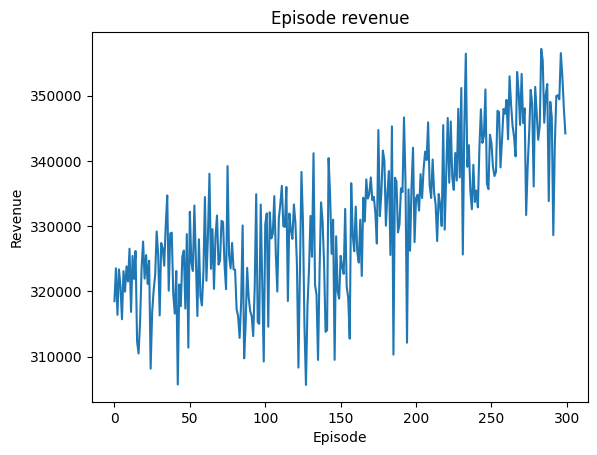

Greedy eval cumulative revenue: 343621.7238343188


In [15]:
# Plot learning
plt.plot(all_rewards); plt.title("Episode revenue"); plt.xlabel("Episode"); plt.ylabel("Revenue")
plt.show()

# Quick evaluation: greedy policy
state = env.reset()
done=False
cum=0.0
while not done:
    a_idx = select_action(state, eps=0.0)
    price = base_price_map[env.skus[env.current_sku]] * action_multipliers[a_idx]
    ns, r, done, info = env.step(price)
    cum += r
    state = ns
print("Greedy eval cumulative revenue:", cum)